In [209]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

sns.set_theme()
plt.rcParams['figure.facecolor'] = 'lightgrey'
plt.rcParams['axes.facecolor'] = 'lightgrey'
plt.rcParams['font.family'] = 'serif'

### Airline Passengers

In [210]:
df1 = pd.read_excel("Airline Passengers.xlsx")
df1['Month'] = pd.to_datetime(df1['Month'], format="%Y-%m")
df1.set_index("Month", inplace=True)
df1.sort_index()
print("Min Date",df1.index.min())
print("Max Date", df1.index.max())
print(df1.info())
df1.head()

Min Date 2015-01-01 00:00:00
Max Date 2019-12-01 00:00:00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2015-01-01 to 2019-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  60 non-null     int64
dtypes: int64(1)
memory usage: 960.0 bytes
None


,Passengers
Month,
2015-01-01,1120
2015-02-01,1180
2015-03-01,1320
2015-04-01,1450
2015-05-01,1600


In [211]:
def split_sets(df, test_size=4, val_size=8):
    test_set = df[-test_size:]             
    val_set = df[-(test_size + val_size):-test_size] 
    train_set = df[:-(test_size + val_size)]
    return train_set.asfreq('MS'), val_set.asfreq('MS'), test_set.asfreq('MS')

train, val, test = split_sets(df1)

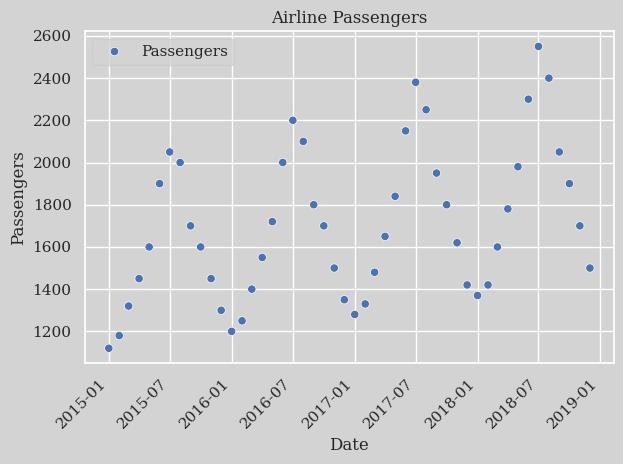

In [212]:
sns.scatterplot(data=train)
plt.title("Airline Passengers")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 
plt.show()

There's a clear upward trend going on. It's stable so we can say that the trend component is additive. Although its not as obvious as the seasonality.

Seasonality exist every year with peak of passengers around the middle of the year (most likely summer) and then goes back down at each ends of the year.

Minimal randomness can be found.

Looking at this simple line plot, it appears the seasonality is **multiplicative**. This is evident with increase in the magnitude of fluctuation as trend increases.

Since there is a clear trend and multiplicative seasonality (period=12 or yearly), we will choose a Holt-Winters Multiplicative Model. Needless to say, the said model takes into account all that we need in Airline Passengers dataset.

In [213]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

Note that instead of grasping for parameter estimate, ExponentialSmoothing from statsmodel has its own optimation algorithm which aims to estimate model parameters by maximizing the log-likelihood.

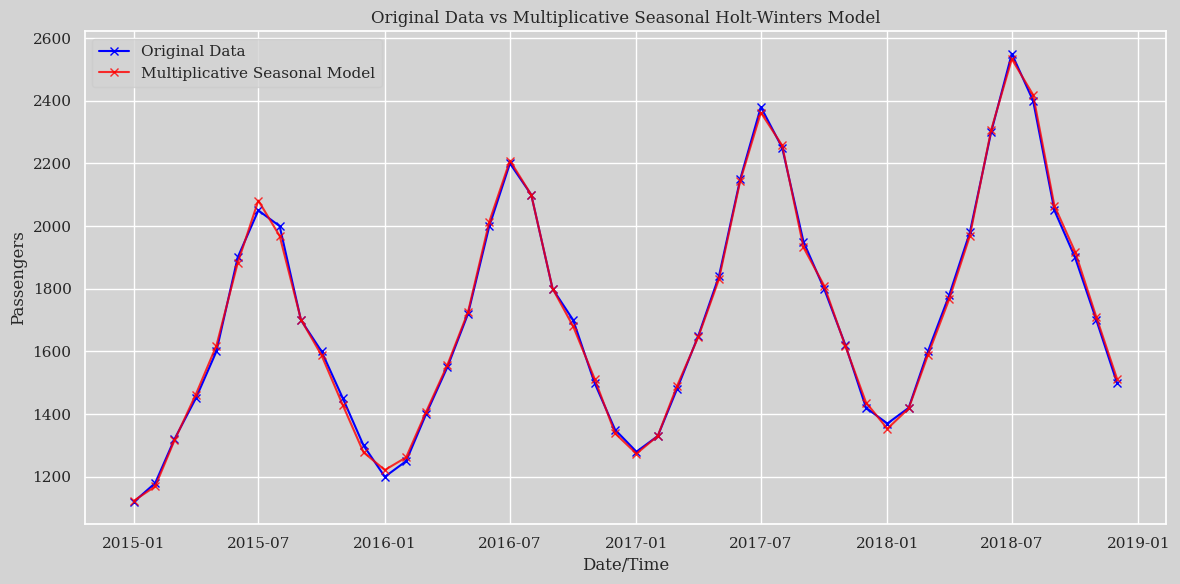

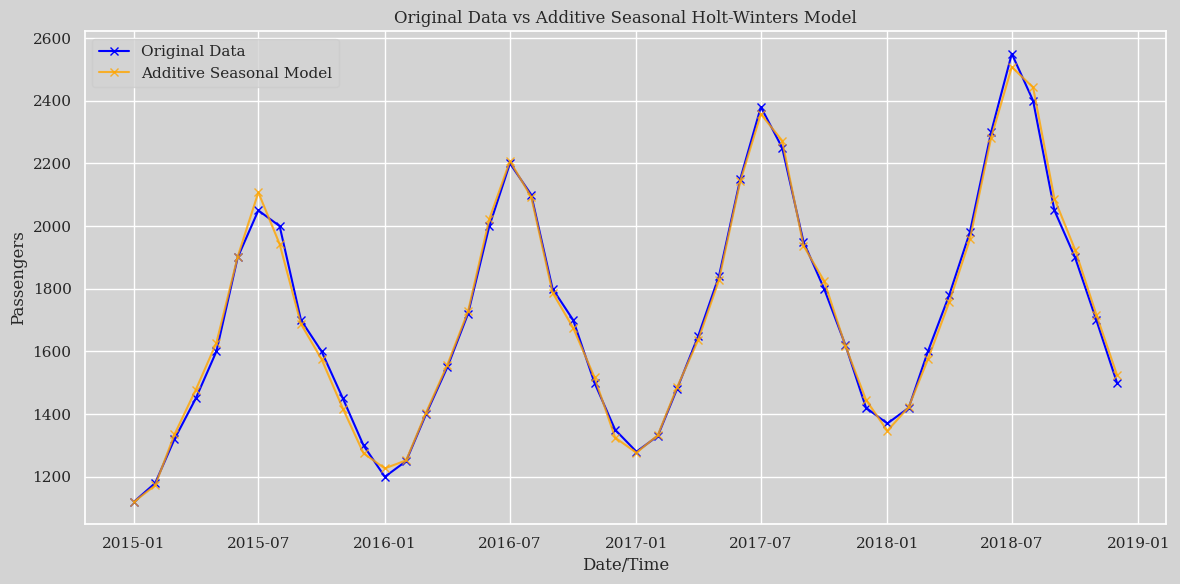

Multiplicative Holt-Winters Model:
                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                   48
Model:             ExponentialSmoothing   SSE                           9391.857
Optimized:                         True   AIC                            285.267
Trend:                         Additive   BIC                            315.206
Seasonal:                Multiplicative   AICC                           308.853
Seasonal Periods:                    12   Date:                 Thu, 25 Sep 2025
Box-Cox:                          False   Time:                         17:19:18
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4881576                alpha            

In [214]:

model_mul = ExponentialSmoothing(
    train['Passengers'],
    trend='add',
    seasonal='mul', 
    seasonal_periods=12  
).fit()

model_add = ExponentialSmoothing(
    train['Passengers'],
    trend='add',
    seasonal='add', 
    seasonal_periods=12  
).fit()

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Passengers'], 'x-', label='Original Data', color='blue')
plt.plot(train.index, model_mul.fittedvalues, 'x-', label='Multiplicative Seasonal Model', color='red', alpha=0.8)
plt.title('Original Data vs Multiplicative Seasonal Holt-Winters Model')
plt.xlabel('Date/Time')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Passengers'], 'x-', label='Original Data', color='blue')
plt.plot(train.index, model_add.fittedvalues, 'x-', label='Additive Seasonal Model', color='orange', alpha=0.8)
plt.title('Original Data vs Additive Seasonal Holt-Winters Model')
plt.xlabel('Date/Time')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Multiplicative Holt-Winters Model:")
print(model_mul.summary())
print("\nAdditive Holt-Winters Model:")
print(model_add.summary())

The additive model seemed to overestimate the seasonality in the earlier part (around 2015) while eventually underestimating the latter part (around 2019). This is a reinforcement to the 'multiplicative' nature of our seaonal component as the multiplicative model seems to handle the increasing amplitude of the seasonal patterns very well. The difference between model is subtle in graph but apparent in their own summary. SSE, BIC, and AIC are all lower in multiplicative model. This is a testament to our choice assessment of the appropriate model earlier.

**Chosen Model: Multiplicative Holts-Winter**

1. Alpha = 0.488 (Level Smoothing) - With an alpha level of around 50%, the model deem it best to have the recent data and historical data have equal weights. This imply a moderate volatility so the smoothing is not too smooth and not too reactive.

2. Beta = 0.000 (Trend Smoothing) - This indicates that the trend is very stable and that the trend does not accelerate nor decelerate.

3. Gamma = 0.000 (Seasonal Smoothing) - seonality is another stable component that does not change overtime.

Overall the model indicates minimal volatilitily and the amount of passengers remain stable as time goes by.

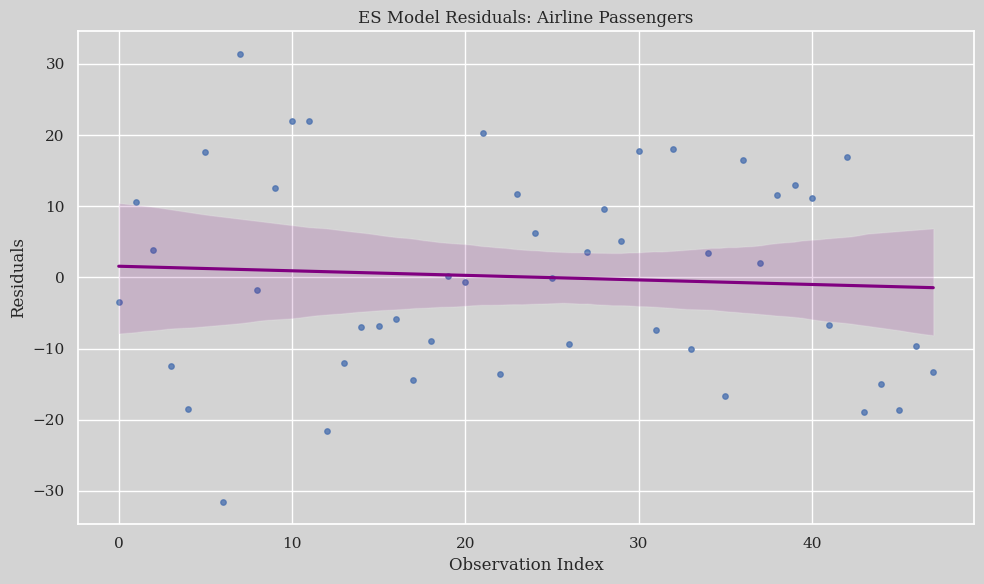

In [215]:
plt.figure(figsize=(10, 6))
indices = np.arange(len(model_mul.resid))
sns.regplot(x=indices, y=model_mul.resid, scatter_kws={'s': 15}, line_kws={'color': 'purple'})
plt.title("ES Model Residuals: Airline Passengers")
plt.xlabel("Observation Index")
plt.ylabel("Residuals")
plt.tight_layout() 
plt.show()

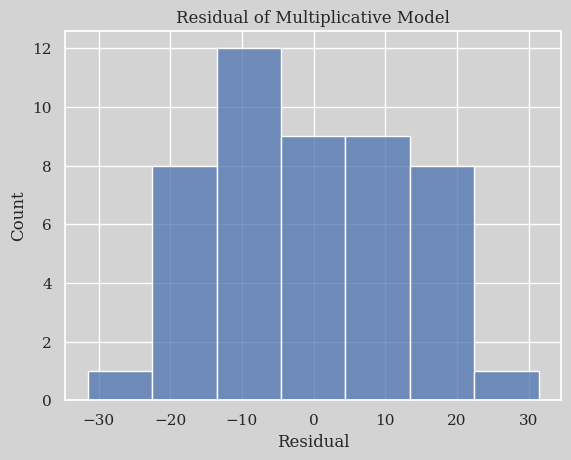

In [216]:
sns.histplot(model_mul.resid)

plt.title("Residual of Multiplicative Model")
plt.xlabel("Residual");

Residuals looks random and (approximately) normaly distributed, as evident by the relatively flat LOESS line and data points hovering around 0.

In [217]:
def progressive_validation(train_set, val_set, forecast_horizon=4, seasonal_type='mul'):
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    
    results = []
    
    n_steps = len(val_set) - forecast_horizon + 1
    
    for step in range(n_steps):
        if step == 0:
            current_train = train_set
        else:
            val_to_include = val_set[:step]
            current_train = pd.concat([train_set, val_to_include])
        
        test_start = step 
        test_end = test_start + forecast_horizon
        test_window = val_set[test_start:test_end]
        
        if len(test_window) < forecast_horizon:
            break
        
        model = ExponentialSmoothing(
            current_train,
            trend='add',
            seasonal=seasonal_type,
            seasonal_periods=12
        ).fit()
        
        forecast = model.forecast(steps=forecast_horizon)
        
        errors = test_window.values - forecast.values
        mape = np.mean(np.abs(errors / test_window.values)) * 100
        mad = np.mean(np.abs(errors))
        msd = np.mean(errors ** 2)
        
        results.append({
            'step': step + 1,
            'train_size': len(current_train),
            'MAPE': mape,
            'MAD': mad,
            'MSD': msd,
            'test_period': f"{test_window.index[0].strftime('%Y-%m')} to {test_window.index[-1].strftime('%Y-%m')}"
        })
    
    results_df = pd.DataFrame(results)
    
    print(f"AVERAGE PERFORMANCE({seasonal_type}):")
    print(f"MAPE: {results_df['MAPE'].mean():.2f}% (+- {results_df['MAPE'].std():.2f}%)")
    print(f"MAD:  {results_df['MAD'].mean():.2f} (+- {results_df['MAD'].std():.2f})")
    print(f"MSD:  {results_df['MSD'].mean():.2f} (+- {results_df['MSD'].std():.2f})")
    
    return results_df

prog_results_mul = progressive_validation(train, val, forecast_horizon=4, seasonal_type='mul')
prog_results_add = progressive_validation(train, val, forecast_horizon=4, seasonal_type='add')

print("\nMultiplicative Model Results:")
print(prog_results_mul)

print("\nAdditive Model Results:")
print(prog_results_add)

AVERAGE PERFORMANCE(mul):
MAPE: 13.41% (+- 2.41%)
MAD:  272.19 (+- 66.64)
MSD:  121785.64 (+- 56047.82)
AVERAGE PERFORMANCE(add):
MAPE: 13.02% (+- 2.26%)
MAD:  269.04 (+- 67.12)
MSD:  114194.02 (+- 53166.66)

Multiplicative Model Results:
   step  train_size       MAPE         MAD            MSD         test_period
0     1          48  11.328857  186.594180   55557.747073  2019-01 to 2019-04
1     2          49  13.862951  246.242824   94304.166380  2019-02 to 2019-05
2     3          50  15.508246  314.571978  156251.091891  2019-03 to 2019-06
3     4          51  15.847865  359.574617  198742.988421  2019-04 to 2019-07
4     5          52  10.517825  253.985547  104072.219768  2019-05 to 2019-08

Additive Model Results:
   step  train_size       MAPE         MAD            MSD         test_period
0     1          48  10.885435  181.144789   50900.473892  2019-01 to 2019-04
1     2          49  13.288086  239.061476   85559.517732  2019-02 to 2019-05
2     3          50  15.037249  31

Basically the function is a walk forward validation. Here are the process:
1. Train a model from original current training set
2. Forecast upto given forecast horizon.
3. Calculate the (accuracy metrics)/forecast horizon
4. Add another actual data point to the current training set.
5. Go back to step 1 (until remaining data points cannot accomodate for forecast horizon)

AVERAGE PERFORMANCE(mul):
MAPE: 0.85% (+- 0.53%)
MAD:  17.72 (+- 11.08)
MSD:  421.38 (+- 360.84)
AVERAGE PERFORMANCE(add):
MAPE: 1.39% (+- 0.73%)
MAD:  28.34 (+- 15.07)
MSD:  1001.79 (+- 828.45)
AVERAGE PERFORMANCE(mul):
MAPE: 13.41% (+- 2.41%)
MAD:  272.19 (+- 66.64)
MSD:  121785.64 (+- 56047.82)
AVERAGE PERFORMANCE(add):
MAPE: 13.02% (+- 2.26%)
MAD:  269.04 (+- 67.12)
MSD:  114194.02 (+- 53166.66)


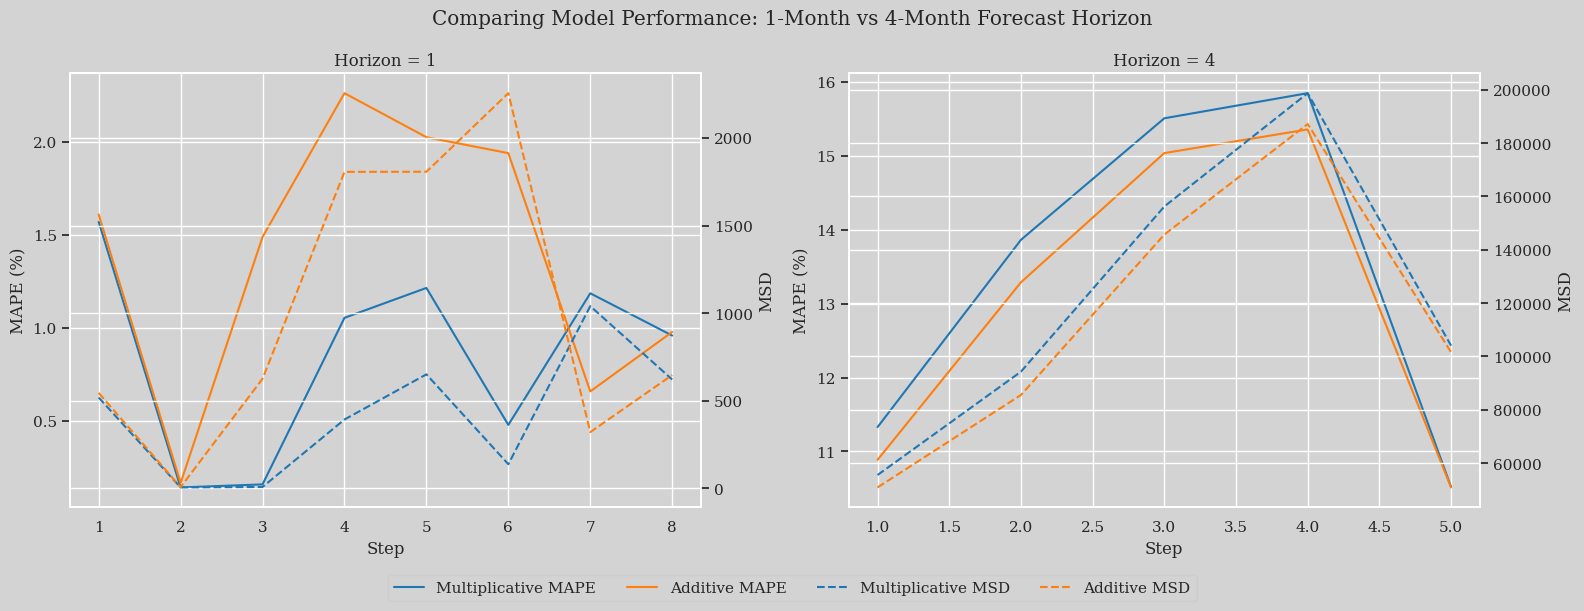

In [218]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axes[0]
ax3 = ax1.twinx()

# horizon = 1
prog_results_mul_1 = progressive_validation(train, val, forecast_horizon=1, seasonal_type='mul')
prog_results_add_1 = progressive_validation(train, val, forecast_horizon=1, seasonal_type='add')


ax1.plot(prog_results_mul_1['step'], prog_results_mul_1['MAPE'], color='tab:blue', label="Multiplicative MAPE")
ax1.plot(prog_results_add_1['step'], prog_results_add_1['MAPE'], color='tab:orange', label="Additive MAPE")
ax1.set_ylabel('MAPE (%)')
ax1.set_xlabel('Step')


ax3.plot(prog_results_mul_1['step'], prog_results_mul_1['MSD'], color='tab:blue', linestyle='--', label="Multiplicative MSD")
ax3.plot(prog_results_add_1['step'], prog_results_add_1['MSD'], color='tab:orange', linestyle='--', label="Additive MSD")
ax3.set_ylabel('MSD')

ax1.set_title("Horizon = 1")
ax1.grid(True)


ax2 = axes[1]
ax4 = ax2.twinx()

# horizon = 4
prog_results_mul_4 = progressive_validation(train, val, forecast_horizon=4, seasonal_type='mul')
prog_results_add_4 = progressive_validation(train, val, forecast_horizon=4, seasonal_type='add')

ax2.plot(prog_results_mul_4['step'], prog_results_mul_4['MAPE'], color='tab:blue', label="Multiplicative MAPE")
ax2.plot(prog_results_add_4['step'], prog_results_add_4['MAPE'], color='tab:orange', label="Additive MAPE")
ax2.set_ylabel('MAPE (%)')
ax2.set_xlabel('Step')

ax4.plot(prog_results_mul_4['step'], prog_results_mul_4['MSD'], color='tab:blue', linestyle='--', label="Multiplicative MSD")
ax4.plot(prog_results_add_4['step'], prog_results_add_4['MSD'], color='tab:orange', linestyle='--', label="Additive MSD")
ax4.set_ylabel('MSD')

ax2.set_title("Horizon = 4")
ax2.grid(True)


lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=4)

plt.suptitle("Comparing Model Performance: 1-Month vs 4-Month Forecast Horizon")
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

The graph above showed an important nuance when choosing an appropriate time series model:
1. Multiplicative Holt-Winter Model: Multiplicative model seemed to perform better on lower forecast horizon with lower MAPE and MSD among all steps. 
2. Additive Model: Additive model seemed to perform better on higher forecast horizon with lower MAPE and MSD among all steps.

This discrepancy maybe due to overestimation of multiplicative seasonality of in multiplicative model the further we forecast (from the actual observations) while the additive is more conservative in their forecast. This nuance give us an important consideration in choosing which model to take use. If we only want a model with horizon of only one (or short-term forecast), multiplicative model is better model while increasing the horizon (long term forecast) paves way to a better additive model.

MAPE: 13.99%
MAE: 258.06
STD ERROR: 554.2434213116513


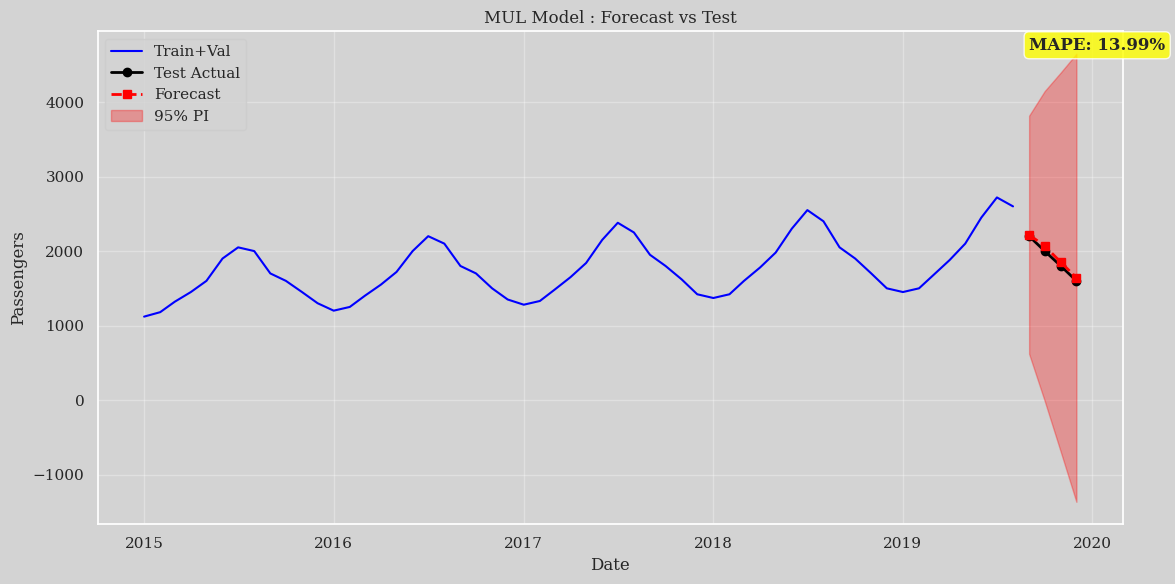

In [220]:
def final_model_evaluation(train_set, val_set, test_set, seasonal):
        from statsmodels.tsa.holtwinters import ExponentialSmoothing

        train_val = pd.concat([train_set, val_set])

        model = ExponentialSmoothing(
        train_val,
        trend='add',
        seasonal=seasonal,
        seasonal_periods=12
        ).fit()

        forecast = model.forecast(steps=len(test_set))

        mape = np.mean(np.abs((test_set.values - forecast.values) / test_set.values)) * 100


        fitted = model.fittedvalues
        residuals = train_val.values - fitted.values  
        std_error = np.std(residuals[~np.isnan(residuals)])  # Remove NaN values

        forecast_errors = []
        for i in range(len(test_set)):
                h = i + 1
                # Std formula for Holt-Winters models
                se = std_error * np.sqrt(1 + h + (h**2)/6)
                forecast_errors.append(se)

        lower_bound = forecast.values - 1.96 * np.array(forecast_errors)
        upper_bound = forecast.values + 1.96 * np.array(forecast_errors)

        print(f"MAPE: {mape:.2f}%")
        print(f"MAE: {np.mean(np.abs(test_set.values - forecast.values)):.2f}")
        print(f"STD ERROR: {std_error}")
        plt.figure(figsize=(12, 6))

        # Plot historical data
        plt.plot(train_val.index, train_val.values, 
                label='Train+Val', color='blue')

        # Plot test actual and forecast
        plt.plot(test_set.index, test_set.values, 
                'o-', label='Test Actual', color='black', linewidth=2)
        plt.plot(test_set.index, forecast.values, 
                's--', label='Forecast', color='red', linewidth=2)

        # Plot prediction intervals
        plt.fill_between(test_set.index, lower_bound, upper_bound,
                        alpha=0.3, color='red', label='95% PI')

        # Add MAPE annotation
        plt.text(test_set.index[0], plt.ylim()[1] * 0.95, 
                f'MAPE: {mape:.2f}%',
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

        plt.title(f'{seasonal.upper()} Model : Forecast vs Test')
        plt.xlabel('Date')
        plt.ylabel('Passengers')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        return model, forecast, mape

model, forecast, mape = final_model_evaluation(train, val, test, seasonal='mul')

MAPE: 17.64%
MAE: 310.25
STD ERROR: 553.4369619274127


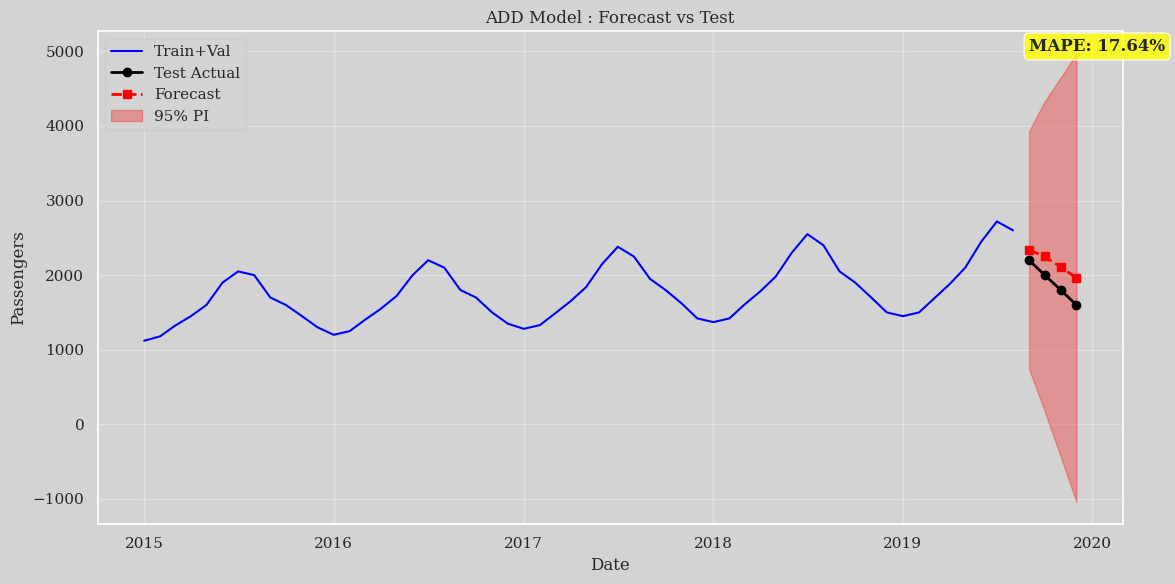

In [221]:
model, forecast, mape = final_model_evaluation(train, val, test, seasonal='add')

This is actually interesting since in this case, even though the horizon=4, the multiplicative seemed to performed better. Why is this the case?
1. In the latest data (test set), there may be an apparent and clear multiplicative seasonal patterns which matches with the Multiplicative Holt-Winters Model.
2. Additive model remain robust when the horizon increases accross multiple and varrying periods due to its conservatism.

In simple words, additive is stable and robust but **multiplicative model remains the more appropriate model to forecast for this particular dataset**.


---

## CPI

In [ ]:
df2 = pd.read_excel("CPI.xlsx")

df2['Year'] = df2['Quarter'].str.split('-').str[0].astype(int)
df2['Q'] = df2['Quarter'].str.split('-').str[1].str[1].astype(int)

df2['Date'] = pd.PeriodIndex(year=df2['Year'], quarter=df2['Q'], freq='Q').to_timestamp()
df2.set_index('Date', inplace=True)

df2 = df2.drop(['Year', 'Q', 'Quarter'], axis=1)

df2.sort_index(inplace=True)
print("Min Date",df2.index.min())
print("Max Date", df2.index.max())

Min Date 2010-01-01 00:00:00
Max Date 2019-10-01 00:00:00


D:\tmp\ipykernel_11032\3991139837.py:6: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.
  df2['Date'] = pd.PeriodIndex(year=df2['Year'], quarter=df2['Q'], freq='Q').to_timestamp()


In [ ]:
def split_sets(df, test_size=4, val_size=8):
    test_set = df[-test_size:]             
    val_set = df[-(test_size + val_size):-test_size] 
    train_set = df[:-(test_size + val_size)]
    return train_set.asfreq('MS'), val_set.asfreq('MS'), test_set.asfreq('MS')

train, val, test = split_sets(df2)

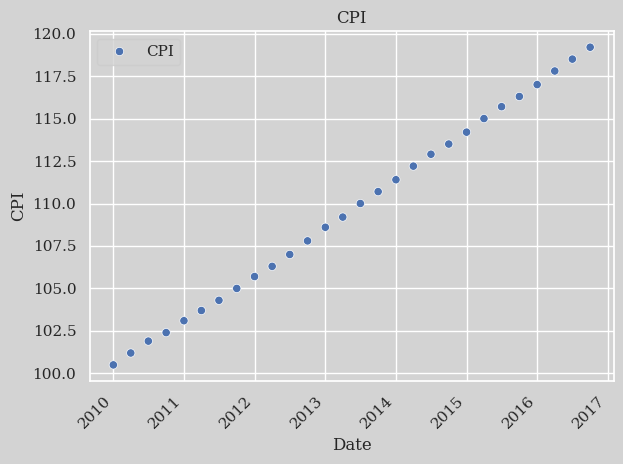

In [ ]:
sns.scatterplot(data=train)
plt.title("CPI")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 
plt.show()

- There is a clear linear trend going on.
- Sesonality on the other hand does not exists.
- No randomness can be found.

Technically, we can just use linear regression to determine this one since it's a clear linear relationship between time and CPI. But for this one, we can actually use Double Exponential Smoothing (Holt's Method) that accounts for both level ($\alpha$) and trend ($\beta$). Although linear model will do well, it might not catch up well with subtle changes in the recent data as opposed to the Holt's method.

Although with the simple nature of the distribution, we can also consider a Simple Exponential Smoothing.

In [ ]:

train_nona = train.squeeze().dropna()
model = Holt(train_nona.values).fit(optimized=True)
model.summary()

Dep. Variable:,endog,No. Observations:,28
Model:,Holt,SSE,0.650
Optimized:,True,AIC,-97.379
Trend:,Additive,BIC,-92.051
Seasonal:,None,AICC,-93.379
Seasonal Periods:,None,Date:,"Thu, 25 Sep 2025"
Box-Cox:,False,Time:,16:03:35
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9939685,alpha,True
smoothing_trend,0.0049059,beta,True


d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


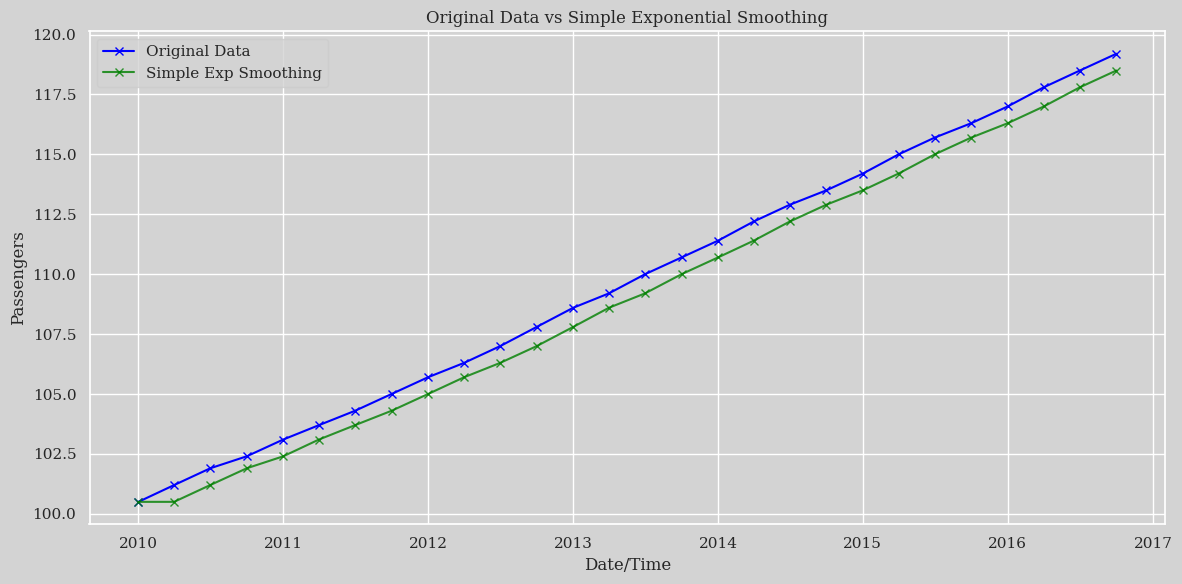

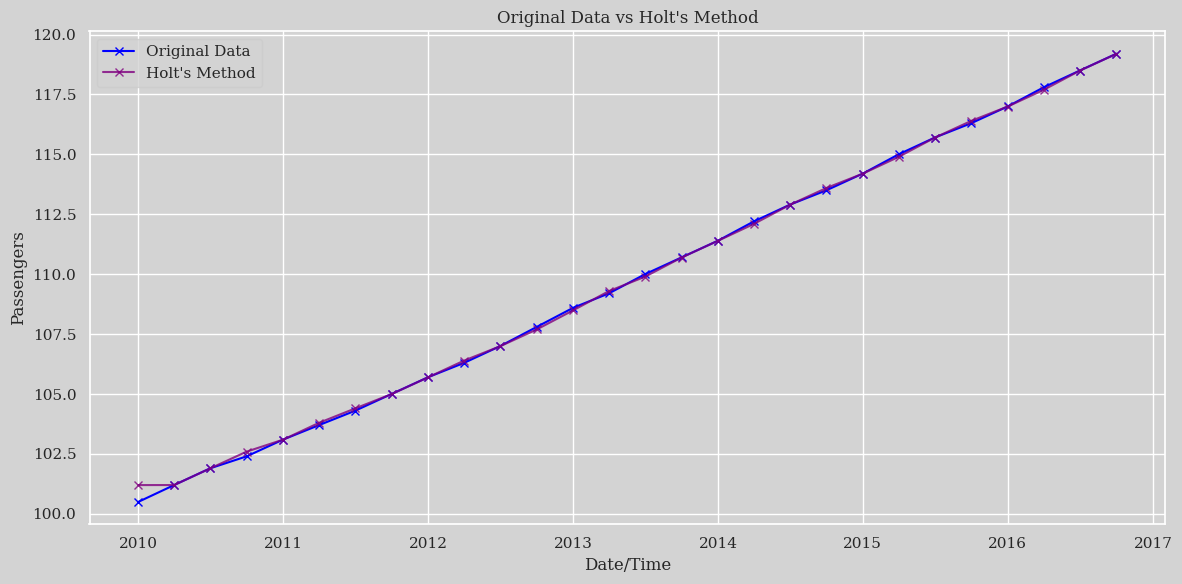

Simple Exponential Smoothing:
                       SimpleExpSmoothing Model Results                       
Dep. Variable:                    CPI   No. Observations:                   28
Model:             SimpleExpSmoothing   SSE                             13.110
Optimized:                       True   AIC                            -17.247
Trend:                           None   BIC                            -14.583
Seasonal:                        None   AICC                           -15.508
Seasonal Periods:                None   Date:                 Thu, 25 Sep 2025
Box-Cox:                        False   Time:                         16:03:37
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
initial_level         

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

train_nona = train.squeeze().dropna()
model_holts = Holt(train_nona).fit(optimized=True)
model_simple = SimpleExpSmoothing(train_nona).fit(optimized=True)

plt.figure(figsize=(12, 6))
plt.plot(train_nona.index, train_nona, 'x-', label='Original Data', color='blue')
plt.plot(train_nona.index, model_simple.fittedvalues, 'x-', label='Simple Exp Smoothing', color='green', alpha=0.8)
plt.title('Original Data vs Simple Exponential Smoothing')
plt.xlabel('Date/Time')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_nona.index, train_nona, 'x-', label='Original Data', color='blue')
plt.plot(train_nona.index, model_holts.fittedvalues, 'x-', label='Holt\'s Method', color='purple', alpha=0.8)
plt.title('Original Data vs Holt\'s Method')
plt.xlabel('Date/Time')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print model summaries
print("Simple Exponential Smoothing:")
print(model_simple.summary())
print("\nHolt's Method:")
print(model_holts.summary())

From the graph above, it becomes clear which is the better model. 
1. Simple ES consistently lags behind and does not capture the trend (there's a visible and consitent gap between the two). 

This is just a thought but can we just add a specifc constant to the model to match the original data since the gap between them is consistent enough? In this case, we were able to actually capture the trend while preserving the simplicity that a Simple ES model has. Well although this might work on this particular range, this solution might not be as robust to a set of values outside of train set.

2. Holt's Method on the other hand fits the data extremely well! It does capture the trend real well. 

**Chosen model is Holt's Method**

1. Alpha = 	0.993 (Level Smoothing) - With a alpha level of almost 1, smoothed series is equals to the original data. Which means the model is giving very high weight to recent observations and very little to historical values.

2. Beta = 0.004 (Trend Smoothing) - This indicates that the trend is very stable and that the trend does not accelerate nor decelerate.

The Holt's Method parameters tell us that the best way to forecast is to start with the most recent value and add a fairly constant rate of increase (which is what was missing in Simple Exponential model).

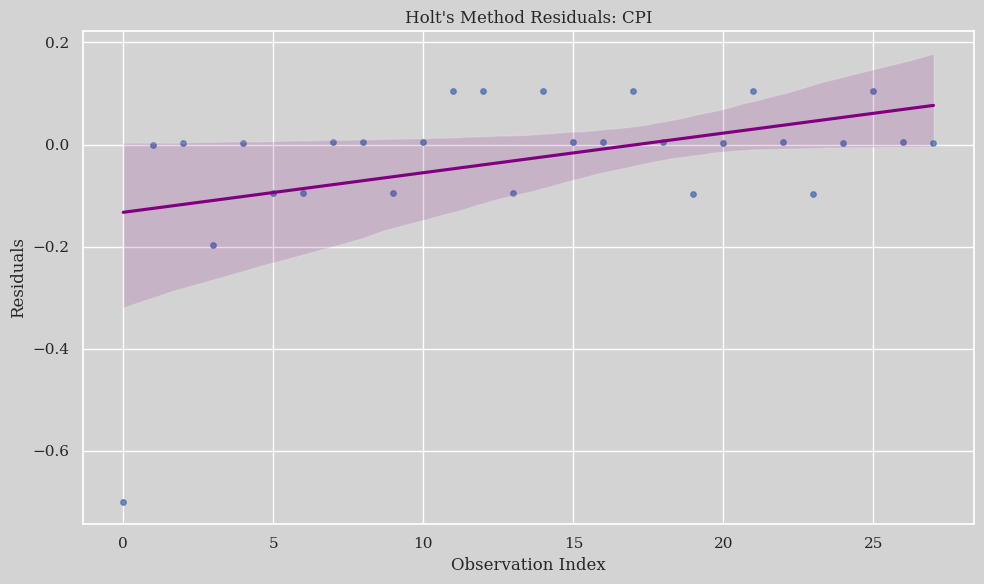

In [ ]:
plt.figure(figsize=(10, 6))
indices = np.arange(len(model_holts.resid))
sns.regplot(x=indices, y=model_holts.resid, scatter_kws={'s': 15}, line_kws={'color': 'purple'})
plt.title("Holt's Method Residuals: CPI")
plt.xlabel("Observation Index")
plt.ylabel("Residuals")
plt.tight_layout() 
plt.show()

This is interesting since althought all residuals are close to 0, there might be subtle acceleration going on with the trend. Maybe the trend component isn't additive but rather multiplicative?


d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


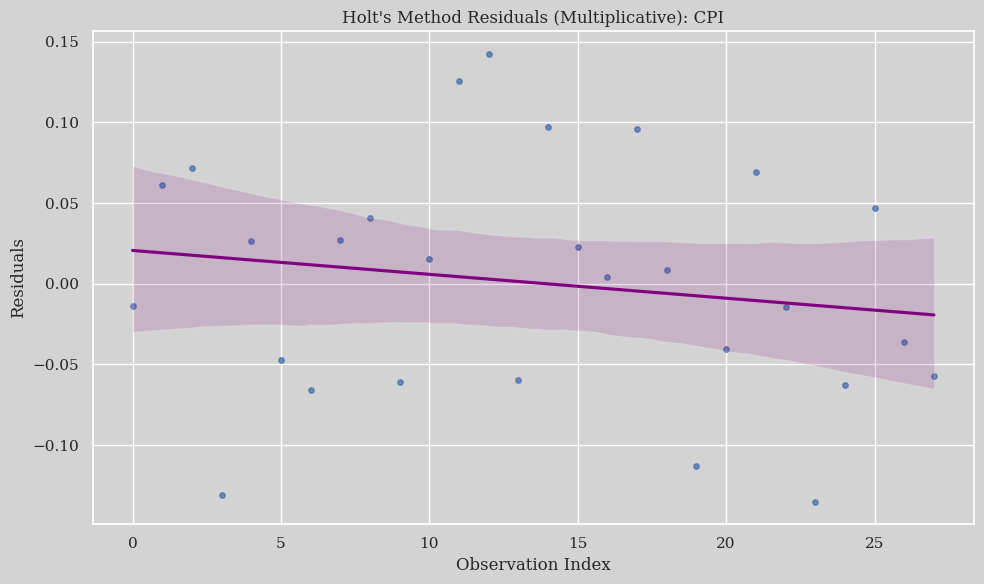

In [ ]:
model_mul = ExponentialSmoothing(train_nona, trend='mul').fit()

plt.figure(figsize=(10, 6))
indices = np.arange(len(model_mul.resid))
sns.regplot(x=indices, y=model_mul.resid, scatter_kws={'s': 15}, line_kws={'color': 'purple'})
plt.title("Holt's Method Residuals (Multiplicative): CPI")
plt.xlabel("Observation Index")
plt.ylabel("Residuals")
plt.tight_layout() 
plt.show()

It actually made it worse (just by the mere fact that the magnitude of residuals increases) while not being able to fix the left-over linear trend.

Theretically speaking we can catch the remaining pattern in residual with: Additive Holt's Method + Linear model of residuals

But this is added complexity and by the magnitude of the residuals left in Additive Holt's Method, we can make this by this alone.  Given the already excellent fit, the marginal improvement from modeling residuals likely doesn't justify the added complexity.

In [ ]:
def progressive_validation(train_set, val_set, forecast_horizon=4):    
    results = []
    
    # Maximum number of steps we can take
    n_steps = len(val_set) - forecast_horizon + 1
    
    
    for step in range(n_steps):
        if step == 0:
            current_train = train_set
        else:
            val_to_include = val_set[:step]
            current_train = pd.concat([train_set, val_to_include])
        
        # Test window slides by 1 each time
        test_start = step 
        test_end = test_start + forecast_horizon
        test_window = val_set[test_start:test_end]
        
        # Skip if not enough data
        if len(test_window) < forecast_horizon:
            break
        

        model = Holt(current_train).fit(optimized=True)

        
        # Forecast
        forecast = model.forecast(steps=forecast_horizon)
        
        # Calculate metrics
        errors = test_window.values - forecast.values
        mape = np.mean(np.abs(errors / test_window.values)) * 100
        mad = np.mean(np.abs(errors))
        msd = np.mean(errors ** 2)
        
        results.append({
            'step': step + 1,
            'train_size': len(current_train),
            'MAPE': mape,
            'MAD': mad,
            'MSD': msd,
            'test_period': f"{test_window.index[0].strftime('%Y-%m')} to {test_window.index[-1].strftime('%Y-%m')}"
        })
        
    
    results_df = pd.DataFrame(results)
    
    print(f"AVERAGE PERFORMANCE:")
    print(f"MAPE: {results_df['MAPE'].mean():.2f}% (+- {results_df['MAPE'].std():.2f}%)")
    print(f"MAD:  {results_df['MAD'].mean():.2f} (+- {results_df['MAD'].std():.2f})")
    print(f"MSD:  {results_df['MSD'].mean():.2f} (+- {results_df['MSD'].std():.2f})")
    
    return results_df

# Run it
prog_results = progressive_validation(train.dropna(), val.dropna(), forecast_horizon=4)
prog_results

AVERAGE PERFORMANCE:
MAPE: 0.76% (+- 0.02%)
MAD:  0.93 (+- 0.01)
MSD:  1.31 (+- 0.02)


,step,train_size,MAPE,MAD,MSD,test_period
0,1,28,0.773627,0.937506,1.316294,2017-01 to 2017-10
1,2,29,0.769016,0.937500,1.345000,2017-04 to 2018-01
2,3,30,0.764198,0.937500,1.320000,2017-07 to 2018-04
3,4,31,0.739774,0.912500,1.285000,2017-10 to 2018-07
4,5,32,0.745047,0.925000,1.295000,2018-01 to 2018-10


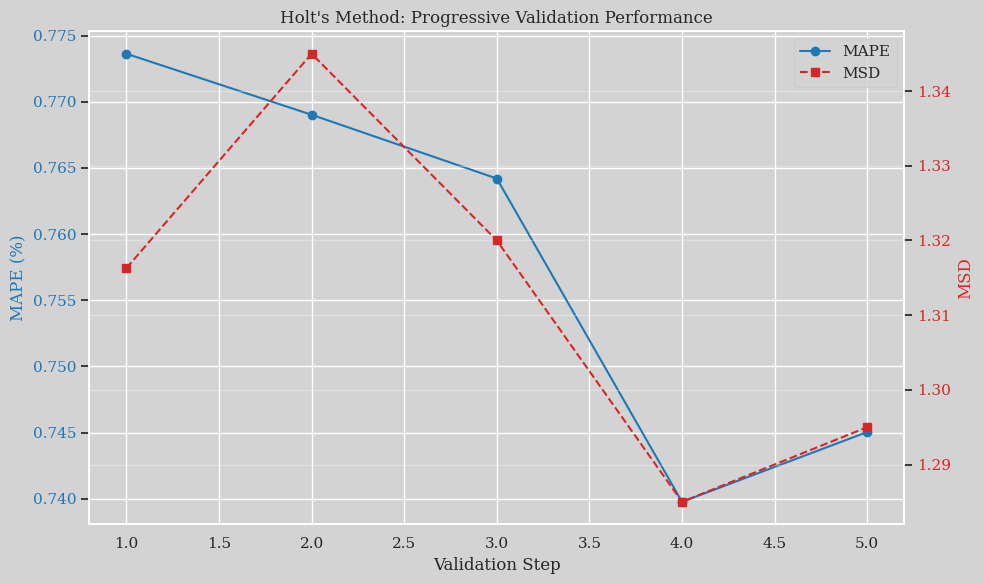

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# MAPE on left axis
color1 = 'tab:blue'
ax1.set_xlabel('Validation Step')
ax1.set_ylabel('MAPE (%)', color=color1)
ax1.plot(prog_results['step'], prog_results['MAPE'], 'o-', color=color1, label="MAPE")
ax1.tick_params(axis='y', labelcolor=color1)

# MSD on right axis
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('MSD', color=color2)
ax2.plot(prog_results['step'], prog_results['MSD'], 's--', color=color2, label="MSD")
ax2.tick_params(axis='y', labelcolor=color2)

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.title("Holt's Method: Progressive Validation Performance")
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

The errors are all <0.8% (MAPE) so we can say that the Holt's model was able to forecast really well in Holt's method.

MAPE: 0.69%
MAE: 0.88
STD ERROR: 10.367327223223368


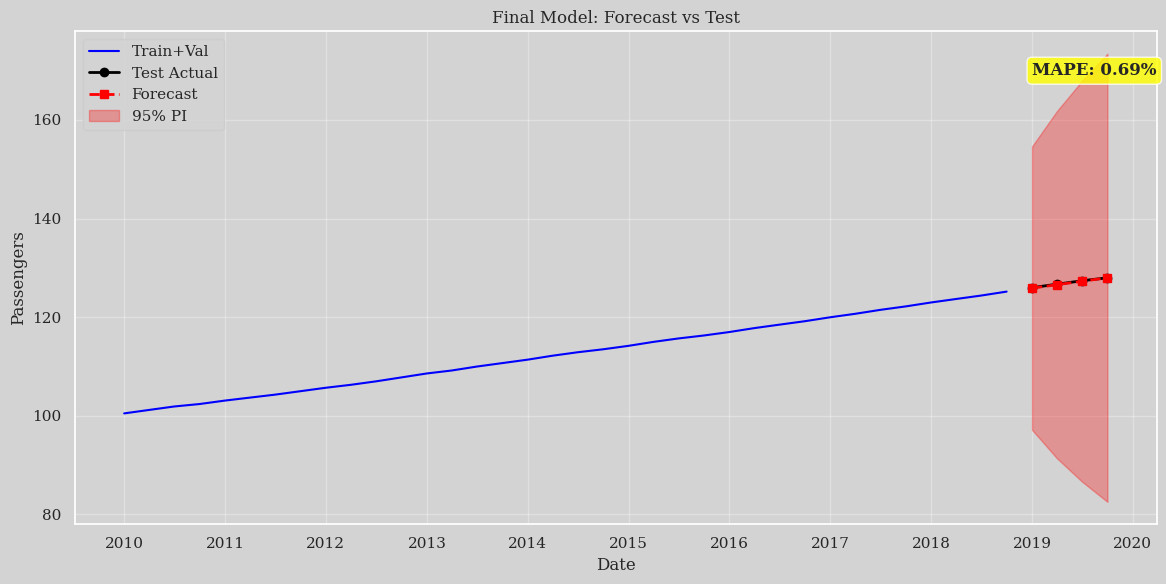

In [ ]:
def final_model_evaluation(train_set, val_set, test_set):
        train_val = pd.concat([train_set, val_set])

        model = Holt(train_val).fit(optimized=True)

        # forecast for test period
        forecast = model.forecast(steps=len(test_set))

        mape = np.mean(np.abs((test_set.values - forecast.values) / test_set.values)) * 100

        # residuals
        fitted = model.fittedvalues
        residuals = train_val.values - fitted.values  
        std_error = np.std(residuals[~np.isnan(residuals)])

        forecast_errors = []
        for i in range(len(test_set)):
                h = i + 1  # horizon
                # formula for Holt's method forecast variance (increases with horizon)
                se = std_error * np.sqrt(1 + h)
                forecast_errors.append(se)

        lower_bound = forecast.values - 1.96 * np.array(forecast_errors)
        upper_bound = forecast.values + 1.96 * np.array(forecast_errors)

        # Print metrics
        print(f"MAPE: {mape:.2f}%")
        print(f"MAE: {np.mean(np.abs(test_set.values - forecast.values)):.2f}")
        print(f"STD ERROR: {std_error}")

        plt.figure(figsize=(12, 6))

        plt.plot(train_val.index, train_val.values, 
                label='Train+Val', color='blue')

        plt.plot(test_set.index, test_set.values, 
                'o-', label='Test Actual', color='black', linewidth=2)
        plt.plot(test_set.index, forecast.values, 
                's--', label='Forecast', color='red', linewidth=2)

        plt.fill_between(test_set.index, lower_bound, upper_bound,
                        alpha=0.3, color='red', label='95% PI')

        plt.text(test_set.index[0], plt.ylim()[1] * 0.95, 
                f'MAPE: {mape:.2f}%',
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

        plt.title('Final Model: Forecast vs Test')
        plt.xlabel('Date')
        plt.ylabel('Passengers')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        return model, forecast, mape

model, forecast, mape = final_model_evaluation(train.dropna(), val.dropna(), test.dropna())

Based from above, it becomes clear that the foreccast 

---

## Ice Cream Sales

In [ ]:
df3 = pd.read_excel("Ice Cream Sales.xlsx")
df3['Month'] = pd.to_datetime(df3['Month'], format="%Y-%m")
df3.set_index("Month", inplace=True)
df3.sort_index()
print("Min Date",df3.index.min())
print("Max Date", df3.index.max())
print(df3.info())
df3.head()

Min Date 2015-01-01 00:00:00
Max Date 2019-12-01 00:00:00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2015-01-01 to 2019-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   60 non-null     int64
dtypes: int64(1)
memory usage: 960.0 bytes
None


,Sales
Month,
2015-01-01,120
2015-02-01,118
2015-03-01,140
2015-04-01,150
2015-05-01,180


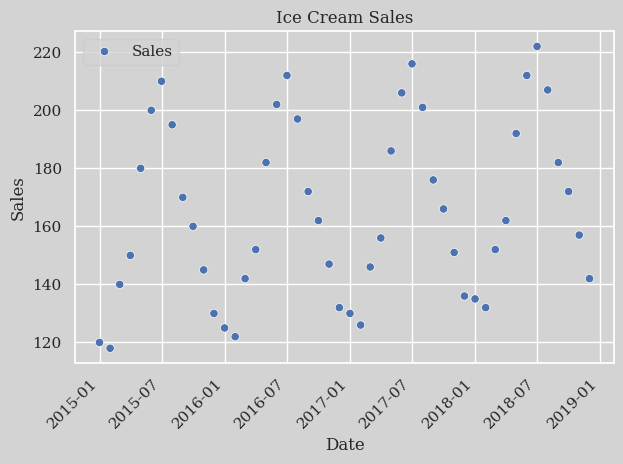

In [ ]:
train, val, test = split_sets(df3)
sns.scatterplot(data=train)
plt.title("Ice Cream Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 
plt.show()

This is simmilar to that of Airline Passengers with minimal randomness, trend (although minimal but stable; so additive) and sesonality but this time it is additive for its magnitude remains constant as time goes by. Therefore, instead of using Multiplicative Holts-Winter (period=12), we shall use its additive equivalent.

In [ ]:
model = ExponentialSmoothing(
    train['Sales'],
    trend='add',
    seasonal='add', 
    seasonal_periods=12  
).fit()

model.summary()

Dep. Variable:,Sales,No. Observations:,48
Model:,ExponentialSmoothing,SSE,13.667
Optimized:,True,AIC,-28.300
Trend:,Additive,BIC,1.640
Seasonal:,Additive,AICC,-4.713
Seasonal Periods:,12,Date:,"Thu, 25 Sep 2025"
Box-Cox:,False,Time:,16:03:07
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,0.000000,beta,True


The coeficient for beta and Gamma too is simillar to the Airplane Passengers dataset but the Alpha is equals to 1.

1. Alpha = 0.488 (Level Smoothing) - With an alpha level of 1, the model gives 100% importance on the most recent values and gives no importance to the past values. This is essentially each forecast is the last observed value + trend + seasonal component.

2. Beta = 0.000 (Trend Smoothing) - This indicates that the trend is very stable and that the trend does not accelerate nor decelerate.

3. Gamma = 0.000 (Seasonal Smoothing) - seonality is another stable component that does not change overtime.

Overall, the ice cream sales model indicates that the sales have fixed seasonal and trend component and relies heavily/solely on the sales from the last month.

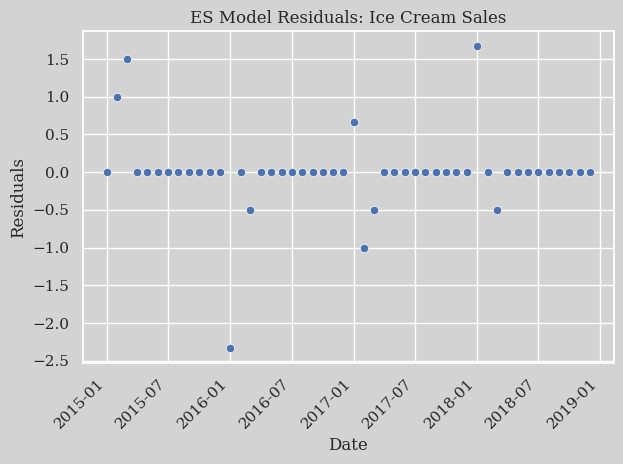

In [ ]:
sns.scatterplot(data=model.resid)
plt.title("ES Model Residuals: Ice Cream Sales")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 
plt.show()

Most are at 0 but there's no any apparent pattern left to discern.

In [ ]:
def progressive_validation(train_set, val_set, forecast_horizon=4):
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    
    results = []
    
    # Maximum number of steps we can take
    n_steps = len(val_set) - forecast_horizon + 1
    
    
    for step in range(n_steps):
        # Expand training set by 'step' periods
        if step == 0:
            current_train = train_set
        else:
            val_to_include = val_set[:step]
            current_train = pd.concat([train_set, val_to_include])
        
        # Test window slides by 1 each time
        test_start = step 
        test_end = test_start + forecast_horizon
        test_window = val_set[test_start:test_end]
        
        # Skip if not enough data
        if len(test_window) < forecast_horizon:
            break
        
        # Fit model
        model = ExponentialSmoothing(
            current_train,
            trend='add',
            seasonal='add',
            seasonal_periods=12
        ).fit()
        
        # Forecast
        forecast = model.forecast(steps=forecast_horizon)
        
        # Calculate metrics
        errors = test_window.values - forecast.values
        mape = np.mean(np.abs(errors / test_window.values)) * 100
        mad = np.mean(np.abs(errors))
        msd = np.mean(errors ** 2)
        
        results.append({
            'step': step + 1,
            'train_size': len(current_train),
            'MAPE': mape,
            'MAD': mad,
            'MSD': msd,
            'test_period': f"{test_window.index[0].strftime('%Y-%m')} to {test_window.index[-1].strftime('%Y-%m')}"
        })
        
    
    results_df = pd.DataFrame(results)
    
    print(f"AVERAGE PERFORMANCE:")
    print(f"MAPE: {results_df['MAPE'].mean():.2f}% (+- {results_df['MAPE'].std():.2f}%)")
    print(f"MAD:  {results_df['MAD'].mean():.2f} (+- {results_df['MAD'].std():.2f})")
    print(f"MSD:  {results_df['MSD'].mean():.2f} (+- {results_df['MSD'].std():.2f})")
    
    return results_df

# Run it
prog_results = progressive_validation(train, val, forecast_horizon=4)
prog_results

AVERAGE PERFORMANCE:
MAPE: 11.43% (+- 3.97%)
MAD:  20.21 (+- 6.89)
MSD:  734.58 (+- 430.71)


,step,train_size,MAPE,MAD,MSD,test_period
0,1,48,9.106318,13.604169,304.486201,2019-01 to 2019-04
1,2,49,14.972674,24.187502,946.312518,2019-02 to 2019-05
2,3,50,14.515915,26.374990,1137.749547,2019-03 to 2019-06
3,4,51,12.902411,25.000008,1050.000223,2019-04 to 2019-07
4,5,52,5.643183,11.875000,234.374946,2019-05 to 2019-08


MAPE: 10.82%
MAE: 17.94
STD ERROR: 43.81392905783495


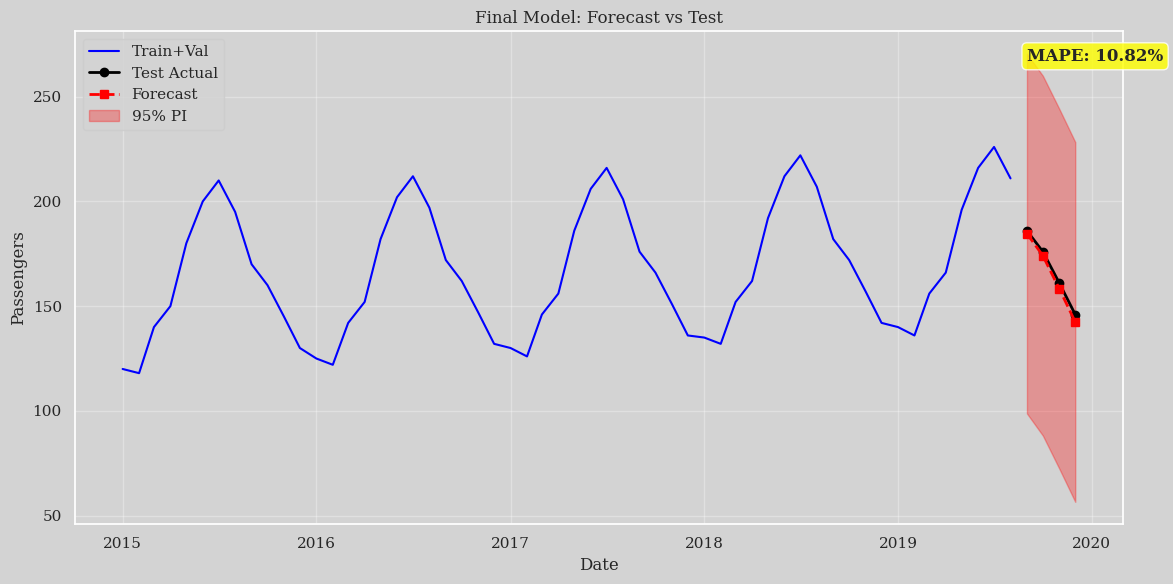

In [ ]:
def final_model_evaluation(train_set, val_set, test_set):
        from statsmodels.tsa.holtwinters import ExponentialSmoothing

        train_val = pd.concat([train_set, val_set])

        model = ExponentialSmoothing(
        train_val,
        trend='add',
        seasonal='mul',
        seasonal_periods=12
        ).fit()

        forecast = model.forecast(steps=len(test_set))

        mape = np.mean(np.abs((test_set.values - forecast.values) / test_set.values)) * 100


        fitted = model.fittedvalues
        residuals = train_val.values - fitted.values  
        std_error = np.std(residuals[~np.isnan(residuals)])  # Remove NaN values

        lower_bound = forecast.values - 1.96 * std_error
        upper_bound = forecast.values + 1.96 * std_error

        print(f"MAPE: {mape:.2f}%")
        print(f"MAE: {np.mean(np.abs(test_set.values - forecast.values)):.2f}")
        print(f"STD ERROR: {std_error}")
        plt.figure(figsize=(12, 6))

        # Plot historical data
        plt.plot(train_val.index, train_val.values, 
                label='Train+Val', color='blue')

        # Plot test actual and forecast
        plt.plot(test_set.index, test_set.values, 
                'o-', label='Test Actual', color='black', linewidth=2)
        plt.plot(test_set.index, forecast.values, 
                's--', label='Forecast', color='red', linewidth=2)

        # Plot prediction intervals
        plt.fill_between(test_set.index, lower_bound, upper_bound,
                        alpha=0.3, color='red', label='95% PI')

        # Add MAPE annotation
        plt.text(test_set.index[0], plt.ylim()[1] * 0.95, 
                f'MAPE: {mape:.2f}%',
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

        plt.title('Final Model: Forecast vs Test')
        plt.xlabel('Date')
        plt.ylabel('Passengers')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        return model, forecast, mape

model, forecast, mape = final_model_evaluation(train, val, test)

---


## Product Demand

In [ ]:
df4 = pd.read_excel("Product Demand.xlsx")
df4.set_index("Week", inplace=True)
df4.sort_index()
print("Min Date",df4.index.min())
print("Max Date", df4.index.max())
print(df4.info())
df4.head()

Min Date 1
Max Date 20
<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 1 to 20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Demand  20 non-null     int64
dtypes: int64(1)
memory usage: 320.0 bytes
None


,Demand
Week,
1,240
2,250
3,245
4,260
5,255


In [ ]:
def split_sets(df, test_size=4, val_size=8):
    test_set = df[-test_size:]             
    val_set = df[-(test_size + val_size):-test_size] 
    train_set = df[:-(test_size + val_size)]
    return train_set, val_set, test_set

train, val, test = split_sets(df4, test_size=2, val_size=6)

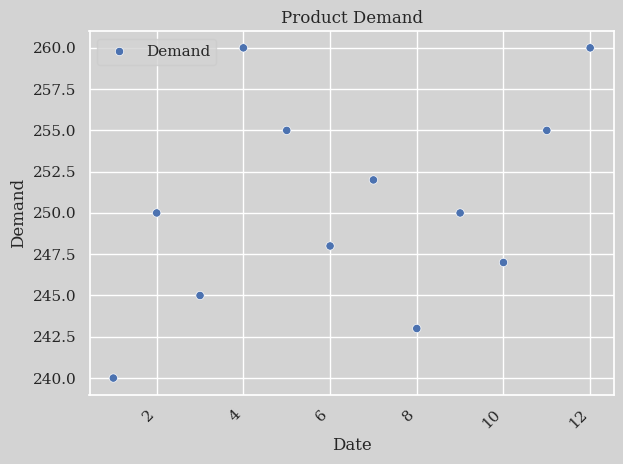

In [ ]:
sns.scatterplot(data=train)
plt.title("Product Demand")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 
plt.show()

It seems that we cannot discern any particular pattern in this one. So for this random dataset, a simple Exponential Smoothing is enough. Of course we could use other and more advanced model but doing so will produce similar result with added complexity. 

d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


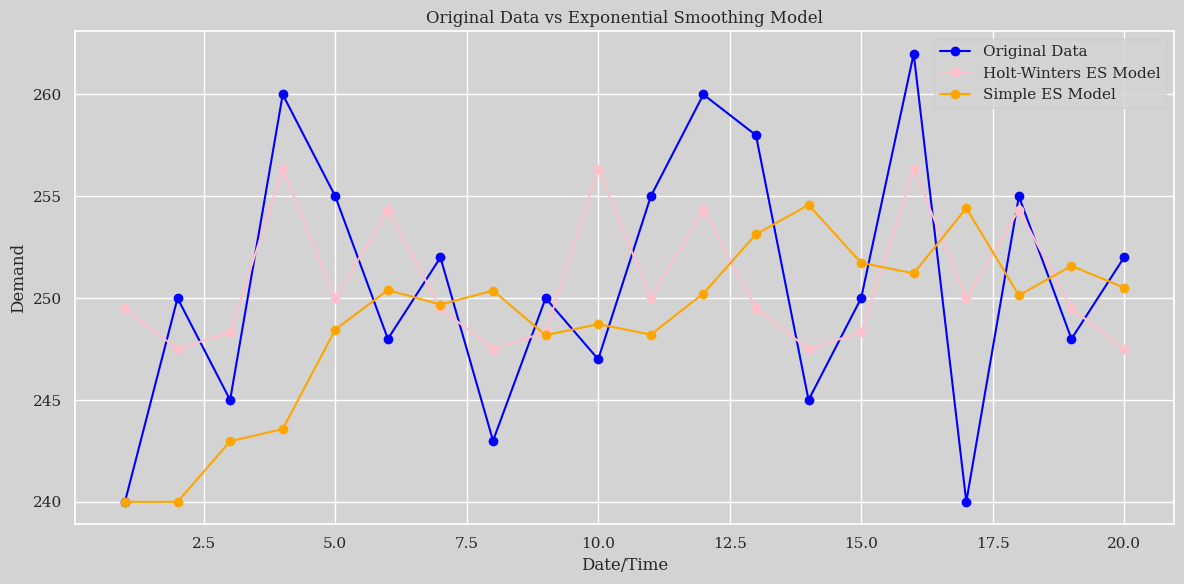

                       ExponentialSmoothing Model Results                       
Dep. Variable:                   Demand   No. Observations:                   20
Model:             ExponentialSmoothing   SSE                            596.000
Optimized:                         True   AIC                             83.890
Trend:                             None   BIC                             91.856
Seasonal:                      Additive   AICC                           108.335
Seasonal Periods:                     6   Date:                 Thu, 25 Sep 2025
Box-Cox:                          False   Time:                         16:03:10
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level              1.4901e-08                alpha                 True
smoothing_seasonal       

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Assuming df4 is already defined with your data
model = ExponentialSmoothing(
    df4['Demand'],
    trend=None,          # No trend
    seasonal='add',      # Additive seasonality
    seasonal_periods=6  
).fit(optimized=True)

# Get the fitted values (in-sample predictions)
fitted_values = model.fittedvalues

# Create a figure and axis
plt.figure(figsize=(12, 6))

# Plot the original data
plt.plot(df4.index, df4['Demand'], 'o-', label='Original Data', color='blue')

plt.plot(df4.index, fitted_values, 'o-', label='Holt-Winters ES Model', color='pink')

fit1 = SimpleExpSmoothing(df4['Demand']).fit(optimized=True)
plt.plot(df4.index, fit1.fittedvalues, 'o-', label='Simple ES Model', color='orange')

# Add title and labels
plt.title('Original Data vs Exponential Smoothing Model')
plt.xlabel('Date/Time')
plt.ylabel('Demand')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

# Print model summary
print(model.summary())

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
fit1 = SimpleExpSmoothing(df4['Demand']).fit(optimized=True)
fit1.summary()

d:\College\Professional\Internship\PWC\lomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Dep. Variable:,Demand,No. Observations:,20
Model:,SimpleExpSmoothing,SSE,1111.462
Optimized:,True,AIC,84.354
Trend:,None,BIC,86.345
Seasonal:,None,AICC,87.021
Seasonal Periods:,None,Date:,"Thu, 25 Sep 2025"
Box-Cox:,False,Time:,16:03:10
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2972220,alpha,True
initial_level,240.00000,l.0,False
